In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import pickle
import json
import cv2
import re

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# create giant dictionary for all data
data_dir = 'mmhs150k/'

# load data and print sizes
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))
print('Length of Tweet Dictionary:', len(tweet_dict))
print('Number of Images:', len(os.listdir(data_dir + 'img_resized')))
print('Number of Image Texts:', len(os.listdir(data_dir + 'img_txt')))

Length of Tweet Dictionary: 149823
Number of Images: 150000
Number of Image Texts: 59252


In [4]:
# method for cleaning text like in https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
def hashtag(text):
    hashtag_body = text.group()[1:]
    if hashtag_body.isupper(): return "<hashtag> {} ".format(hashtag_body.lower())
    else: return ' '.join(["<hashtag>"] + [re.sub(r"([A-Z])",r" \1", hashtag_body, flags=re.MULTILINE | re.DOTALL)])

def allcaps(text): return text.group().lower() + ' <allcaps> '    

def clean_tweet_text(t):
    eyes = r'[8:=;]'
    nose = r"['`\-]?"
    
    t = re.sub(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', '<url>', t)
    t = re.sub(r'@\w+', '<user>', t)
    t = re.sub(r'{}{}[)dD]+|[)dD]+{}{}'.format(eyes, nose, nose, eyes), '<smile>', t)
    t = re.sub(r'{}{}p+".format(eyes, nose)', '<lolface>', t)
    t = re.sub(r'{}{}\(+|\)+{}{}'.format(eyes, nose, nose, eyes), '<sadface>', t)
    t = re.sub(r'{}{}[\/|l*]'.format(eyes, nose), '<neutralface>', t)
    t = re.sub(r'/', ' / ', t)
    t = re.sub(r'<3','<heart>', t)
    t = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', '<number>', t)
    t = re.sub(r'#\S+', hashtag, t)
    t = re.sub(r'([!?.]){2,}', r'\1 <repeat>', t)
    t = re.sub(r'\b(\S*?)(.)\2{2,}\b', r'\1\2 <elong>', t)
    t = re.sub(r'([A-Z]){2,}', allcaps, t)
    t = re.sub(r'{}'.format(r'[\".,-;&:]'), ' ', t)
    return t.lower()
    
print(clean_tweet_text('@SLAAATTTTT @AINTSHlTLAUGHS NIGGA...  DID YOU NOT HEAR THE CHRIS BROWN SONG?!?!?! https://t.co/1hwQMRczOw'))
print(clean_tweet_text(':) :-) 8) #HelloWorld #helloworld #Hello'))

<user> <user> nigga <allcaps>   <repeat>  did <allcaps>  you <allcaps>  not <allcaps>  hear <allcaps>  the <allcaps>  chris <allcaps>  brown <allcaps>  song <allcaps> ! <repeat> <url>
<smile> <smile> <smile> <hashtag>  hello world <hashtag> helloworld <hashtag>  hello


In [5]:
# initialize data dictionary {id: (tweet text, label)}
train_data = []
word_index = dict() # dictionary mapping word to index

def get_data_list(path):
    data = []
    for id in open(data_dir + path, 'r').read().splitlines():

        # process text (tweet special tokens)
        text = tweet_dict[id]['tweet_text']
        text = clean_tweet_text(text)
        for word in text.split():
            if word not in word_index: word_index[word] = len(word_index)

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to list
        data.append((text, label))

    return data
    
train_data = get_data_list('splits/train_ids.txt')
val_data = get_data_list('splits/val_ids.txt')
print('Train data len:', len(train_data))
print('Val data len:', len(val_data))

# print longest training sequence length
texts2, _ = zip(*train_data)
print('Longest training sequence length:', max([len(t.split()) for t in texts2]))

Train data len: 134823
Val data len: 5000
Longest training sequence length: 55


In [7]:
# make the dataset
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NUMBER_OF_WORDS = 100
MAX_SEQ_LEN = 60

# training
texts, labels = zip(*train_data)

tokenizer = Tokenizer(num_words=MAX_NUMBER_OF_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

y_train = np.asarray(labels)
print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

# validation
val_texts, val_labels = zip(*val_data)

val_sequences = tokenizer.texts_to_sequences(val_texts) # apply train tokenizer
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

Found 64960 unique tokens.
Shape of data tensor: (134823, 60)
Shape of label tensor: (134823,)


In [8]:
# embedding layer
from keras.layers import Embedding
EMBEDDING_DIM = 100

# map word to embedding
embeddings_index = {}
for line in open(os.path.join('glove', 'glove.twitter.27B.100d.txt')):
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

# create embedding matrix (words without embeddings get zero embeddings)
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

In [9]:
# validation on subset of training set
from keras.layers import Input, LSTM, Dense
from keras import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# shuffle data
indices = (np.arange(x_train.shape[0]))
np.random.shuffle(indices)
x_train, y_train = x_train[indices], y_train[indices]

history = model.fit(x_train, y_train, epochs=3, batch_size=100, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           6496100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 6,591,801
Trainable params: 95,701
Non-trainable params: 6,496,100
_________________________________________________________________
None
Train on 107858 samples, validate on 26965 samples
Epoch 1/3
107858/107858 [==============================] - 84s 775us/step - loss: 0.4748 - accuracy: 0.7886 - val_loss: 0.4639 - val_accuracy: 0.7944
Epoch 2/3
107858/107858 [======

In [10]:
# validation on validation set
from keras.layers import Input, LSTM, Dense
from keras import Sequential

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(100))
model.add(Dense(150, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

history = model.fit(x_train, y_train, epochs=10, batch_size=100, validation_data=(x_val, y_val))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 100)           6496100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 6,591,801
Trainable params: 95,701
Non-trainable params: 6,496,100
_________________________________________________________________
None
Train on 134823 samples, validate on 5000 samples
Epoch 1/10
134823/134823 [==============================] - 88s 653us/step - loss: 0.4729 - accuracy: 0.7901 - val_loss: 0.7591 - val_accuracy: 0.5840
Epoch 2/10
134823/134823 [=====

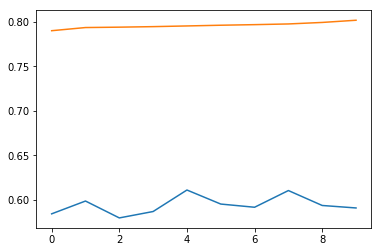

In [11]:
%matplotlib inline
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])